<a href="https://colab.research.google.com/github/LaJeremi/Tensorflow-nlp-tutorial-Practice-/blob/main/12.%20RNN%20Sequence%20Labeling/12_02_Part_of_speech_Tagging_using_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12_02 Part-of-speech Tagging using Bi-LSTM- 양방향 LSTM를 이용한 품사 태깅

출처: https://wikidocs.net/33532

품사 태깅에 대해서는 이미 텍스트 전처리 챕터에서 토큰화와 함께 언급한 바 있습니다. 그 당시에는 NLTK와 KoNLPy를 이용해서 품사 태깅을 수행하였지만, 여기서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델

## 1. 품사 태깅 데이터에 대한 이해와 전처리


In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [ ]:

import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
     

In [ ]:
nltk.download('treebank')


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [ ]:
# 토큰화에 품사 태깅이 된 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


In [ ]:
print(tagged_sentences[0])


[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


품사 태깅 전처리가 수행된 첫번째 문장이 출력

총 3914개 있음. 

 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분 - 품사 태깅 정보에 해당되는 부분을 분리

 Pierre과 Vinken을 같이 저장하고, NNP와 NNP를 같이 저장할 필요가 있음. 

 이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 동일한 순서에 등장하는 원소들끼리 묶어주는 역할



In [ ]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


첫번째 샘플에 대해서 단어에 대해서 sentences[0]에, 품사에 대해서만 pos_tags[0]에 저장된 것을 볼 수 있습니다

뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 pos_tags는 예측 대상인 y에 해당

8번 인덱스도 확인. 

In [ ]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


단어에 대해서만 sentences[8]에, 또한 품사에 대해서만 pos_tags[8]에 저장된 것을 확인

길이는 제각각 분포 확인 후. 샘플 길이가 대부분 0~50의 길이를 가짐. 

토크나이저 실행.

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


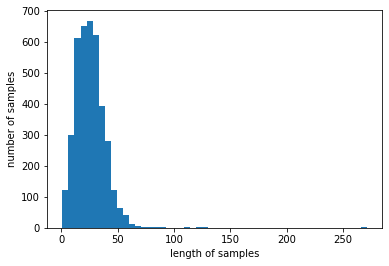

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [ ]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

단어 집합과 태깅 정보의 크기를 확인. 

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


정수 인코딩을 수행

In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [ ]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


샘플들의 모든 길이를 임의로 150정도로 맞춤.

훈련데이터와 테스트 데이터를 8:2의 비율로 분리

In [ ]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

각 데이터에 대한 크기(shape)를 확인해보겠습니다.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


# 2. 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

임베딩 벡터의 차원과 LSTM의 은닉 상태의 차원은 128로 지정

* 다대다 문제이므로 LSTM의 return_sequences의 값은 True로 지정

양방향 사용을 위해 LSTM을 Bidirectional()로 감싸주었습니다.

 validation_data로는 테스트 데이터를 기재하여 학습 중간에 테스트 데이터의 정확도를 확인

### * 레이블에 대해서 원-핫 인코딩을 하고 손실 함수를 categorical_crossentropy를 사용할 수도 있겠지만, 만약 레이블에 원-핫 인코딩을 하지 않고 학습을 진행하고자 한다면 손실 함수를 categorical_crossentropy 대신 sparse_categorical_crossentropy를 선택

여기서는 후자의 방법

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))

Epoch 1/7
25/25 [==============================] - 53s 2s/step - loss: 3.4364 - accuracy: 0.1398 - val_loss: 3.0066 - val_accuracy: 0.1947
Epoch 2/7
25/25 [==============================] - 40s 2s/step - loss: 2.9154 - accuracy: 0.2172 - val_loss: 2.7866 - val_accuracy: 0.2661
Epoch 3/7
25/25 [==============================] - 37s 1s/step - loss: 2.5904 - accuracy: 0.3855 - val_loss: 2.2860 - val_accuracy: 0.4725
Epoch 4/7
25/25 [==============================] - 40s 2s/step - loss: 1.9098 - accuracy: 0.5338 - val_loss: 1.5191 - val_accuracy: 0.6236
Epoch 5/7
25/25 [==============================] - 37s 1s/step - loss: 1.1858 - accuracy: 0.7256 - val_loss: 0.9121 - val_accuracy: 0.8069
Epoch 6/7
25/25 [==============================] - 37s 1s/step - loss: 0.6468 - accuracy: 0.8788 - val_loss: 0.5436 - val_accuracy: 0.8863
Epoch 7/7
25/25 [==============================] - 37s 2s/step - loss: 0.3559 - accuracy: 0.9336 - val_loss: 0.3834 - val_accuracy: 0.9094


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))


25/25 [==============================] - 6s 235ms/step - loss: 0.3832 - accuracy: 0.9094

 테스트 정확도: 0.9094


실제로 맞추고 있는지를 특정 테스트 샘플(10번 인덱스)을 통해 확인/ 정수로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 이용하여 실제값과 예측값을 출력

In [ ]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

1/1 [==============================] - 3s 3s/step
단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
